Before we start we will import all the libraries we will need.

In [1]:
import pandas as pd
import random
import csv
import matplotlib.pyplot as plt
from collections import defaultdict

# 1. Recommendation System with LSH

## 1.1 Data Preparation

Let's download and explore our dataset.

In [2]:
# Loading all the data
movies_df = pd.read_csv('movie.csv')
g_scores_df = pd.read_csv('genome_scores.csv')
g_tags_df = pd.read_csv('genome_tags.csv')
link_df = pd.read_csv('link.csv')
rating_df = pd.read_csv('rating.csv')
tag_df = pd.read_csv('tag.csv')

For this part of the project we will need only the movies and rating df. So we are going to merge them and analyse them.

In [3]:
# Merge the two Data sets
titles_and_ratings_df = pd.merge(movies_df, rating_df) 

In [4]:
titles_and_ratings_df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,2009-01-02 01:13:41
...,...,...,...,...,...,...
20000258,131254,Kein Bund für's Leben (2007),Comedy,79570,4.0,2015-03-30 19:32:59
20000259,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,79570,4.0,2015-03-30 19:48:08
20000260,131258,The Pirates (2014),Adventure,28906,2.5,2015-03-30 19:56:32
20000261,131260,Rentun Ruusu (2001),(no genres listed),65409,3.0,2015-03-30 19:57:46


In [5]:
# Checking for missing values
titles_and_ratings_df.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [64]:
titles_and_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   title      object 
 2   genres     object 
 3   userId     int64  
 4   rating     float64
 5   timestamp  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


In [65]:
# All the kinds of genres
pd.DataFrame(titles_and_ratings_df["genres"].unique(), columns= ["Kinds"])

,Kinds
0,Adventure|Animation|Children|Comedy|Fantasy
1,Adventure|Children|Fantasy
2,Comedy|Romance
3,Comedy|Drama|Romance
4,Comedy
...,...
1324,Adventure|Children|Drama|Sci-Fi
1325,Children|Documentary|Drama
1326,Action|Adventure|Animation|Fantasy|Horror
1327,Animation|Children|Comedy|Fantasy|Sci-Fi


In [66]:
# Total number of users
len(titles_and_ratings_df["userId"].unique())

138493

## 1.2 Minhash Signatures

Using the <strong> userId </strong> and <strong> movieId </strong> columns, implement your own MinHash function. This function will hash each user's watched movie list, creating a representation that allows for quick comparisons of user similarities.

To start with, we are going to create a dictionary that will contain all the movies each user has watched. So as keys we are going to use userId and as values, the movieId.

In [6]:
# Create the dictionary
users_dict = titles_and_ratings_df.groupby('userId')['movieId'].apply(set).to_dict()

Now we can move on and build our own MinHash function.

In [7]:
# First we have to define the hash function
def hash_function(hashes, values, prime):
    # It creates a number of hash functions and puts them in a list
    hashes_list = []
    for i in range(hashes):
        a = random.randint(1, values)
        b = random.randint(0, values)
        hashes_list.append(lambda x, a=a, b=b, p=prime: (a * x + b) % p)
    return hashes_list

In [8]:
# Define MinHash Function
def minhash(movie_set, hashes_list):
    minhash_vector = []
    for i in hashes_list:
        min_hash = min(i(title) for title in movie_set)
        minhash_vector.append(min_hash)
    return minhash_vector

Now if we want to do quick comparisons of user similarities, we have to create a <strong> Jaccard similarity </strong> function.

In [9]:
# Define Jaccard Similarity function using minhash functions
def jaccard_similarity(user1, user2):
    # user1 = signature of the first user
    # user2 = signature of the second user
    similarity = sum(1 for a, b in zip(user1, user2) if a == b) / len(user1)
    return similarity

In [10]:
# Define Actual Jaccard Similarity (using sets)
def actual_jaccard(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

Experiment with different hash functions and threshold values to find the most effective configurations. Report these results. First we will define a function to calculate the mean error for different users.

In [12]:
# Define Mean Error Calculation
def mean_error(users_dict, signature_matrix):
    total_error = 0
    pair_count = 0
    for user1 in users_dict:
        for user2 in users_dict:
            if user1 < user2:  # Avoid duplicate pairs and self-comparison
                # Actual Jaccard similarity
                actual_similarity = actual_jaccard(users_dict[user1], users_dict[user2])
                # Estimated Jaccard similarity from MinHash
                estimated_similarity = jaccard_similarity(signature_matrix[user1], signature_matrix[user2])
                # Add the absolute error
                total_error += abs(actual_similarity - estimated_similarity)
                pair_count += 1
    # Return the mean error
    return total_error / pair_count if pair_count > 0 else 0

As our dataset is too big we will run the experiment by sampling 3000 random users.

In [ ]:
# Experimentation Function for a Sample of Users
def experiment(users_dict, num_hashes_values, thresholds, sample_size):
    results = []
    # Randomly sample users from the dataset
    sampled_users = random.sample(list(users_dict.keys()), sample_size)
    sampled_users_dict = {user: users_dict[user] for user in sampled_users}
    
    max_movie_id = max(max(movies) for movies in users_dict.values())
    prime = 10**9 + 7  # A large prime number
    
    # Iterate over different configurations of num_hashes and threshold
    for num_hashes in num_hashes_values:
        for threshold in thresholds:
            # Generate hash functions
            hashes_list = hash_function(num_hashes, max_movie_id, prime)

            # Generate MinHash signatures for all sampled users
            signature_matrix = {}
            for user, movie_set in sampled_users_dict.items():
                signature_matrix[user] = minhash(movie_set, hashes_list)

            # Calculate the mean error for the current configuration
            mean_error_value = mean_error(sampled_users_dict, signature_matrix)
            results.append((num_hashes, threshold, mean_error_value))
            print(f"Experiment with {num_hashes} hashes and threshold {threshold} - Mean Error: {mean_error_value:.4f}")
    
    # Return the results for all experiments
    return results

Now let's choose the number of hashses, the thresholds, the prime and the maximun values for the experiment. When it comes to values we will choose the biggest movie ID that there is in the dataset.

In [74]:
# Take a sample of users (for large datasets, this is a subset)
sample_size = 3000  # Number of users to sample
prime = 150001
num_hashes_values = [100, 150, 200]
thresholds = [0.5, 0.7, 0.8]
values = max(titles_and_ratings_df['movieId'])

In [75]:
# Run the experiment on the sampled users
results = experiment(users_dict, num_hashes_values, thresholds, sample_size, prime)
# Find the best configuration with the lowest mean error
best_config = min(results, key=lambda x: x[2])
print(f"Best combination is: {best_config[0]} hashes, threshold {best_config[1]} with mean error {best_config[2]:.4f}")

Experiment with 100 hashes and threshold 0.5 - The Mean Error: 0.0140
Experiment with 100 hashes and threshold 0.7 - The Mean Error: 0.0145
Experiment with 100 hashes and threshold 0.8 - The Mean Error: 0.0133
Experiment with 150 hashes and threshold 0.5 - The Mean Error: 0.0113
Experiment with 150 hashes and threshold 0.7 - The Mean Error: 0.0113
Experiment with 150 hashes and threshold 0.8 - The Mean Error: 0.0115
Experiment with 200 hashes and threshold 0.5 - The Mean Error: 0.0099
Experiment with 200 hashes and threshold 0.7 - The Mean Error: 0.0092
Experiment with 200 hashes and threshold 0.8 - The Mean Error: 0.0096
Best combination is: 200 hashes, threshold 0.7 with mean error 0.0092


We are going to visualize the results by plotting them.

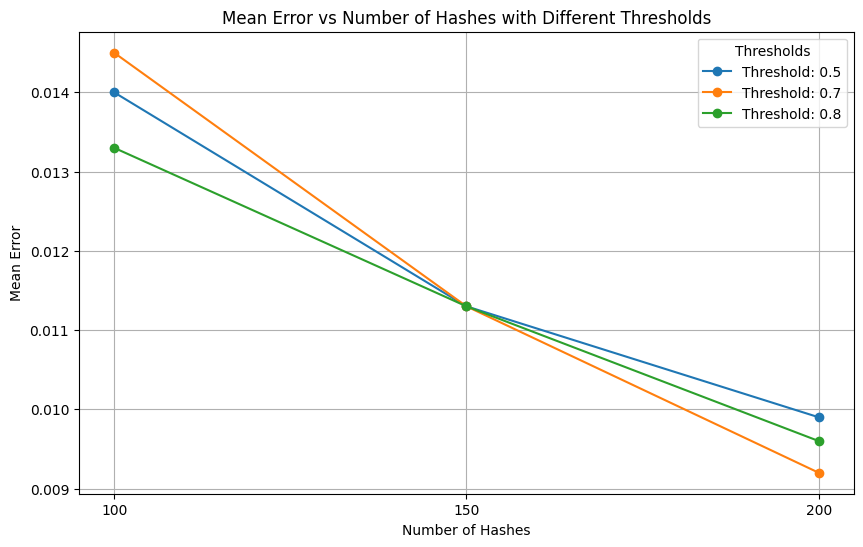

In [76]:
# Data: Experiment results
hashes = [100, 100, 100, 150, 150, 150, 200, 200, 200]
thresholds = [0.5, 0.7, 0.8, 0.5, 0.7, 0.8, 0.5, 0.7, 0.8]
mean_errors = [0.0140, 0.0145, 0.0133, 0.0113, 0.0113, 0.0113, 0.0099, 0.0092, 0.0096]

# Grouping by number of hashes (x-axis) and plotting for each threshold
hashes_unique = sorted(set(hashes))
thresholds_unique = sorted(set(thresholds))

# Create a figure
plt.figure(figsize=(10, 6))

# Loop over thresholds and plot lines for each threshold
for threshold in thresholds_unique:
    threshold_errors = [mean_errors[i] for i in range(len(hashes)) if thresholds[i] == threshold]
    plt.plot(hashes_unique, threshold_errors, marker='o', label=f'Threshold: {threshold}')

# Labeling the axes
plt.title('Mean Error vs Number of Hashes with Different Thresholds')
plt.xlabel('Number of Hashes')
plt.ylabel('Mean Error')

# Add legend
plt.legend(title="Thresholds")

# Show the plot
plt.grid(True)
plt.xticks(hashes_unique)  # Ensuring x-axis ticks are set to unique hash values
plt.show()


## Report
As we can see by increasing the number of hashes we reduce the mean error by achieving the lowest mean error (0.0092) with 200 hashes.
When it comes to the value of thresholds, it effects the results way less than the number of hashes. 
Finally we achieved the lowest mean error by using 200 hashes and 0.7 threshold.

Now we can create a dictionary for all the users 

In [21]:
# MinHash Signature Generation
def minhash_signatures(users_dict, hashes, values):
    hashes_list = hash_function(hashes, values, prime)
    
    # Create MinHash signatures for all users
    signature_matrix = {}
    for user, movie_set in users_dict.items():
        signature_matrix[user] = minhash(movie_set, hashes_list)
    
    return signature_matrix

In [22]:
hashes = 200
prime = 150001
values = max(titles_and_ratings_df['movieId'])


# Generate MinHash signatures for all users in the dataset
signature_matrix = minhash_signatures(users_dict, hashes, values)

## 1.3 Locality-Sensitive Hashing (LSH)

Now that we have generated MinHash user signatures, we will apply Locality-Sensitive Hashing (LSH) to cluster similar users.

1) <strong> Bucket Creation: </strong> For each user, divide the MinHash signature into bands and hash each band to form buckets. Users with similar bands should fall into the same buckets.

In [23]:
def create_buckets(signature_matrix, num_bands, rows_per_band):
    """
    Create LSH buckets by dividing MinHash signature into bands and hashing each band.
    
    
    Returns:
    - buckets: A dictionary of buckets, where the key is the band hash, and the value is a list of users
    """
    buckets = defaultdict(list)
    
    for user, signature in signature_matrix.items():
        # Split the signature into bands
        for i in range(num_bands):
            start_index = i * rows_per_band
            end_index = (i + 1) * rows_per_band
            band = tuple(signature[start_index:end_index])  # Create a tuple of the band
            
            # Hash the band (using a simple hash function)
            band_hash = hash(band)  # You can use a custom hash function if needed
            buckets[band_hash].append(user)
    
    return buckets

In [24]:
# Check the contents of a few buckets (debugging tip)
def check_buckets(buckets, num_samples=5):
    """Print the contents of a few buckets for debugging."""
    for i, (bucket_hash, users) in enumerate(buckets.items()):
        if i >= num_samples:
            break
        print(f"Bucket {i} (Hash: {bucket_hash}): {users}")

The number of bands and rows per band has to be equal to: b * r = hashes. We choose 200 hashes.

In [25]:
# Set parameters 
num_bands = 10
rows_per_band = 20

# Create the LSH buckets
buckets = create_buckets(signature_matrix, num_bands, rows_per_band)

# Check the buckets to ensure users are grouped properly
check_buckets(buckets)

Bucket 0 (Hash: -7400468256567758958): [1]
Bucket 1 (Hash: -7629808275392122178): [1]
Bucket 2 (Hash: -3450412916942225252): [1]
Bucket 3 (Hash: -2835098239069653929): [1]
Bucket 4 (Hash: -3208175470550973363): [1]


In [26]:
# Create clusters
clusters = [users for users in buckets.values() if len(users) > 1]
print(f"Total clusters found: {len(clusters)}")
for cluster in clusters[:5]:  # Display the first 5 clusters
    print(f"Cluster: {cluster}")

Total clusters found: 2658
Cluster: [13, 36800]
Cluster: [13, 24947, 58930, 76529, 91009, 98676, 128513, 135496]
Cluster: [26, 7790]
Cluster: [26, 74881, 113079]
Cluster: [39, 65635]


Now, for a given user, identify the two most similar users based on their bucket placement. If a user doesn’t have any similar users in their bucket, adjust the parameters until similar users are found

In [27]:
def find_similar_users(user_id, buckets, users_dict, threshold=0.7):
    """
    Find the two most similar users based on Jaccard similarity, using LSH buckets.
    
    Returns:
    - most_similar_users: List of two users most similar to the given user
    """
    user_movies = users_dict[user_id]
    most_similar_users = []
    highest_similarity = 0
    
    # Iterate over all buckets to find the user's bucket
    for band_hash, users in buckets.items():
        if user_id in users:
            # For each user in the same bucket, calculate Jaccard similarity
            for other_user_id in users:
                if other_user_id != user_id:  # Avoid comparing the user with themselves
                    other_user_movies = users_dict[other_user_id]
                    similarity = actual_jaccard(user_movies, other_user_movies)
                    
                    # If similarity is higher than the threshold, update the most similar users
                    if similarity > threshold and similarity > highest_similarity:
                        highest_similarity = similarity
                        most_similar_users = [user_id, other_user_id]
    
    # Return the most similar users (if any)
    if most_similar_users:
        return most_similar_users, highest_similarity
    else:
        return None, 0  # If no similar users are found within the threshold

In [29]:
# Example usage for a specific user (e.g., user 158)
user_id = 158
most_similar, similarity = find_similar_users(user_id, buckets, users_dict, threshold=0.7)
print(f"Most similar users to user 1: {most_similar} with similarity: {similarity}")

Most similar users to user 1: None with similarity: 0


Movie Recommendation Logic:

If both similar users have rated a movie, recommend this movie based on the average rating.
If there are no commonly rated movies, recommend the top-rated movies of the most similar user.

In [ ]:
def recommend_movies(user_id, similar_users, rating_df, movies_df, users_dict):
    """
    Recommend movies for a given user based on the most similar users and their ratings, including movie titles.
    
    Returns:
        A DataFrame with recommended movies and corresponding information.
    """
    user_recommendations = []
    similar_user1, similar_user2 = similar_users  

    # Get ratings for the similar users
    user1_ratings = rating_df[rating_df['userId'] == similar_user1]
    user2_ratings = rating_df[rating_df['userId'] == similar_user2]

    # Find common movies rated by both similar users
    user1_movies = set(user1_ratings['movieId'])
    user2_movies = set(user2_ratings['movieId'])
    common_movies = user1_movies.intersection(user2_movies)

    if common_movies:
        # Add common movies with average ratings
        for movie in common_movies:
            rating1 = user1_ratings[user1_ratings['movieId'] == movie]['rating'].values[0]
            rating2 = user2_ratings[user2_ratings['movieId'] == movie]['rating'].values[0]
            avg_rating = (rating1 + rating2) / 2

            movie_title = movies_df[movies_df['movieId'] == movie]['title'].values[0]
            user_recommendations.append({'Target User': user_id, 
                                         'Similar User': f'User {similar_user1} & {similar_user2}', 
                                         'Movie ID': movie, 
                                         'Title': movie_title, 
                                         'Rating': avg_rating})

    # Add top-rated movies from both similar users
    top_rated_user1 = user1_ratings.sort_values(by='rating', ascending=False)
    top_rated_user2 = user2_ratings.sort_values(by='rating', ascending=False)

    # Avoid recommending already included movies
    already_recommended = {rec['Movie ID'] for rec in user_recommendations}

    # Add top-rated movies from similar user 1
    for _, row in top_rated_user1.iterrows():
        if len(user_recommendations) >= 5:
            break
        if row['movieId'] not in already_recommended:
            movie_title = movies_df[movies_df['movieId'] == row['movieId']]['title'].values[0]
            user_recommendations.append({'Target User': user_id, 
                                         'Similar User': similar_user1, 
                                         'Movie ID': row['movieId'], 
                                         'Title': movie_title, 
                                         'Rating': row['rating']})

    # Add top-rated movies from similar user 2
    for _, row in top_rated_user2.iterrows():
        if len(user_recommendations) >= 5:
            break
        if row['movieId'] not in already_recommended:
            movie_title = movies_df[movies_df['movieId'] == row['movieId']]['title'].values[0]
            user_recommendations.append({'Target User': user_id, 
                                         'Similar User': similar_user2, 
                                         'Movie ID': row['movieId'], 
                                         'Title': movie_title, 
                                         'Rating': row['rating']})

    # Finalize the recommendations (ensure we get only top 5)
    recommendations_df = pd.DataFrame(user_recommendations)

    # Ensure each row represents a unique user with their own recommendations
    recommendations_df = recommendations_df.head(5)  # Limit to 5 recommendations

    return recommendations_df

In [ ]:
# Example usage of Recommend movies 
user_id = 3
similar_users = [1999, 111111]
recommended_movies = recommend_movies(user_id, similar_users, rating_df, movies_df, users_dict)

print(recommended_movies)

   Target User        Similar User  Movie ID                            Title  \
0            3  User 1999 & 111111      1285                  Heathers (1989)   
1            3  User 1999 & 111111      3081             Sleepy Hollow (1999)   
2            3  User 1999 & 111111      1036                  Die Hard (1988)   
3            3  User 1999 & 111111      3087                  Scrooged (1988)   
4            3  User 1999 & 111111      2710  Blair Witch Project, The (1999)   

   Rating  
0    4.75  
1    3.75  
2    4.25  
3    3.75  
4    2.50  
